# Pion decay simulation

Simulate the decay
$$
\pi^+ \rightarrow \mu^+\nu_\mu
$$

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import vector
import pandas as pd

# Set up the basic particle parameters, based on the kinetic energy of the beam

Use

\begin{align*}
   E &= K+mc^2 \\
   pc &= \sqrt{E^2-\left(mc^2\right)^2}\\
   \gamma &= \frac E{mc^2}\\
   \beta &= \frac {pc}{E}
\end{align*}


In [2]:
# Constants
c = 299792458          # m/s
m_pi = 139.57039     # pion rest mass [MeV/c^2]
m_mu = 105.6583745   # muon rest mass
m_nu = 0               # neutrino rest mass
tau_pi = 2.6033e-8     # pion lifetime

# Simulation parameters
N = 50000
K_pi_lab = 1e3           # Kinetic energy of pion [MeV]
E_pi_lab = K_pi_lab+m_pi # Total energy of pions in the lab 
p_pi_lab = np.sqrt(E_pi_lab**2-m_pi**2)
                   

# Buid a 4-vector
pion_lab = vector.obj(
    px = 0,
    py = 0,
    pz = p_pi_lab,
    E  = E_pi_lab
)

# --- Relativistic factors from vector object ---
beta = pion_lab.beta
gamma = pion_lab.gamma

print(f"Pion β = {beta:.6f}, γ = {gamma:.3f}")

Pion β = 0.992471, γ = 8.165


Calculate the decay position using 
$$
L = \gamma\beta\tau
$$

In [3]:
# --- Decay times and lengths ---
# Exponential decay times in the rest frame of the pion
t_proper = np.random.exponential(scale=tau_pi, size=N)

# apply dilation
t_lab = gamma * t_proper
decay_length = beta * c * t_lab

print(f"Mean decay length: {decay_length.mean():.3f} m")

Mean decay length: 63.012 m


# Calculate the momentum of the muon using

$$
     p_\mu = \left(m_\pi^2 - (m_\mu+m_\nu)^2\right)\left(m_\pi^2 - (m_\mu-m_\nu)^2\right)c
$$

In [4]:
# --- Two-body decay kinematics in pion rest frame ---
p_mu_star = np.sqrt(
    (m_pi**2 - (m_mu + m_nu)**2) *
    (m_pi**2 - (m_mu - m_nu)**2)
) / (2 * m_pi)


# Create an istropic distribution

In [5]:
# isotropic angles
cosθ = np.random.uniform(-1, 1, size=N)
sinθ = np.sqrt(1 - cosθ**2)
phi = np.random.uniform(0, 2*np.pi, size=N)

# muon momentum in pion rest frame
px_star = p_mu_star * sinθ * np.cos(phi)
py_star = p_mu_star * sinθ * np.sin(phi)
pz_star = p_mu_star * cosθ

E_mu_star = np.full(N,np.sqrt(p_mu_star**2 + m_mu**2))

# Histogram these in the rest frame

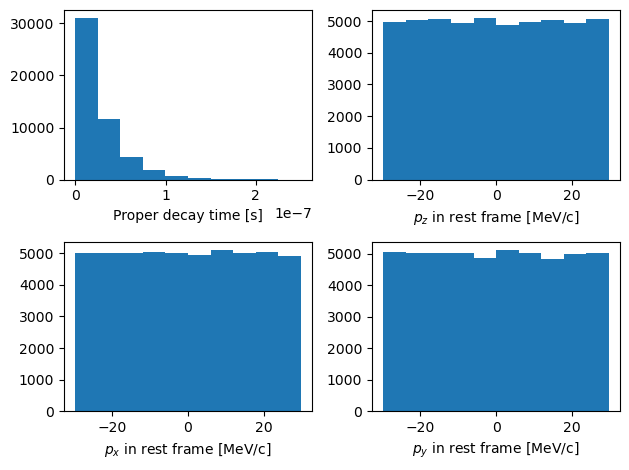

In [6]:
fig,ax = plt.subplots(2,2)

# Proper time
ax[0,0].hist(t_proper)
ax[0,0].set_xlabel('Proper decay time [s]')
# z momentum
ax[0,1].hist(pz_star)
ax[0,1].set_xlabel(r'$p_z$ in rest frame [MeV/c]')
ax[1,0].hist(px_star)
ax[1,0].set_xlabel(f'$p_x$ in rest frame [MeV/c]')
ax[1,1].hist(py_star)
ax[1,1].set_xlabel(f'$p_y$ in rest frame [MeV/c]')
plt.tight_layout()
plt.show()

In [7]:
mu_rest = vector.array({
    "px": px_star,
    "py": py_star,
    "pz": pz_star,
    "E":  E_mu_star
})

# --- Boost all muons into the lab frame ---
mu_lab = mu_rest.boost_p4(pion_lab)

# We now have full lab-frame muon 4-vectors!
p_mu_lab = mu_lab.p
E_mu_lab = mu_lab.E

print(f"Mean muon lab momentum: {p_mu_lab.mean()/1e3:.3f} GeV")
print(f"Max muon lab momentum:  {p_mu_lab.max()/1e3:.3f} GeV")


# Put everything into a pandas dataframe
muons = pd.DataFrame({'zdecay':decay_length,'px':mu_lab.px,'py':mu_lab.py,'pz':mu_lab.pz})

Mean muon lab momentum: 0.890 GeV
Max muon lab momentum:  1.133 GeV


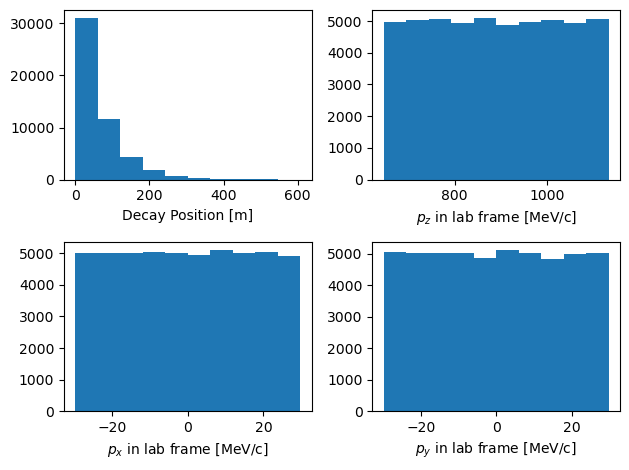

In [8]:
# Historgram some stuff
fig,ax = plt.subplots(2,2)
# z position of decay
ax[0,0].hist(muons['zdecay'])
ax[0,0].set_xlabel('Decay Position [m]')
# z momentum
ax[0,1].hist(muons['pz'])
ax[0,1].set_xlabel(r'$p_z$ in lab frame [MeV/c]')
ax[1,0].hist(muons['px'])
ax[1,0].set_xlabel(f'$p_x$ in lab frame [MeV/c]')
ax[1,1].hist(muons['py'])
ax[1,1].set_xlabel(f'$p_y$ in lab frame [MeV/c]')
plt.tight_layout()
plt.show()

In [11]:
# Define the detector
zdet = 200.    # Z of the detector
xsize = 6.     # xsize of the detector
ysize = 6.     # ysize of the detector
rhole = .05     # hole in the detector

muons['xdet'] = muons['px']/muons['pz']*(zdet-muons['zdecay'])
muons['ydet'] = muons['py']/muons['pz']*(zdet-muons['zdecay'])
muons['rdet'] = np.sqrt(muons['xdet']**2 + muons['ydet']**2)
total = len(muons)

mdec = muons.query(f'zdecay<{zdet}')

hits = mdec.query(f'abs(xdet)<{xsize/2.} and abs(ydet)<{ysize/2.} and rdet>{rhole}')
misses = mdec.query(f'abs(xdet)>={xsize/2.} or abs(ydet)>={ysize/2.}')
holes = mdec.query(f' rdet<{rhole}')

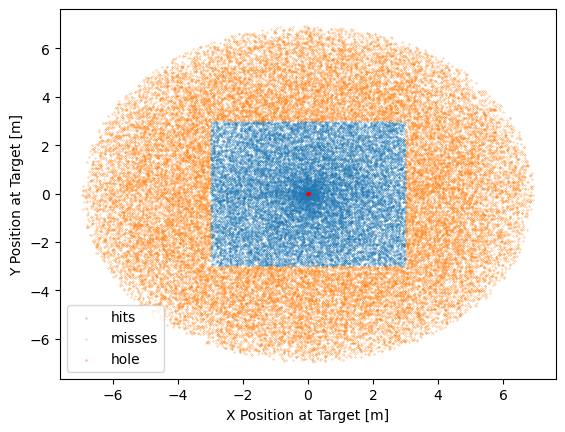

In [13]:
plt.scatter(hits['xdet'],hits['ydet'],s=.05,label='hits')
plt.scatter(misses['xdet'],misses['ydet'],s=.05,label='misses')
plt.scatter(holes['xdet'],holes['ydet'],color='r',s=.05,label='hole')
plt.xlabel('X Position at Target [m]')
plt.ylabel('Y Position at Target [m]')
plt.legend()
plt.show()

In [14]:
# Print out the statistics
fdecay = 100.*len(mdec)/len(muons)
fhit = 100.*len(hits)/len(mdec)
fmiss = 100.*len(misses)/len(mdec)
fhole = 100.*len(holes)/len(mdec)
print(f'{fdecay:.2f}% decayed upstream of the detector. Of these:')
print(f'{fhit:.2f}% hit the detector.')
print(f'{fmiss:.2f}% were outside the detector.')
print(f'{fhole:.2f}% went down the hole detector.')


95.71% decayed upstream of the detector. Of these:
37.47% hit the detector.
62.35% were outside the detector.
0.18% went down the hole detector.
